---
# 0. 라이브러리
----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 45.3 MB/s eta 0:00:00


[참고 사이트](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial16/Meta_Learning.html)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns 
import pandas as pd
import os
import random
import json
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy


import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

# Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

---
# 2. Data
----

In [5]:
# CIFAR 데이터 다운로드
CIFAR_train_set = CIFAR100(root='./', train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root='./', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


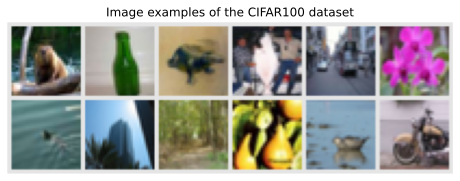

In [6]:
# 데이터 확인
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [7]:
CIFAR_train_set.data[0].shape

(32, 32, 3)

In [8]:
CIFAR_train_set.class_to_idx.items()

dict_items([('apple', 0), ('aquarium_fish', 1), ('baby', 2), ('bear', 3), ('beaver', 4), ('bed', 5), ('bee', 6), ('beetle', 7), ('bicycle', 8), ('bottle', 9), ('bowl', 10), ('boy', 11), ('bridge', 12), ('bus', 13), ('butterfly', 14), ('camel', 15), ('can', 16), ('castle', 17), ('caterpillar', 18), ('cattle', 19), ('chair', 20), ('chimpanzee', 21), ('clock', 22), ('cloud', 23), ('cockroach', 24), ('couch', 25), ('crab', 26), ('crocodile', 27), ('cup', 28), ('dinosaur', 29), ('dolphin', 30), ('elephant', 31), ('flatfish', 32), ('forest', 33), ('fox', 34), ('girl', 35), ('hamster', 36), ('house', 37), ('kangaroo', 38), ('keyboard', 39), ('lamp', 40), ('lawn_mower', 41), ('leopard', 42), ('lion', 43), ('lizard', 44), ('lobster', 45), ('man', 46), ('maple_tree', 47), ('motorcycle', 48), ('mountain', 49), ('mouse', 50), ('mushroom', 51), ('oak_tree', 52), ('orange', 53), ('orchid', 54), ('otter', 55), ('palm_tree', 56), ('pear', 57), ('pickup_truck', 58), ('pine_tree', 59), ('plain', 60), ('

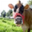

In [9]:
Image.fromarray(CIFAR_train_set.data[0])

---
# 3. Preprocessing
---

- 학습, 검증, 테스트 분할을 위해 기존 테스트와 학습을 위한 데이터셋을 병합 후 3가지로 재분해

In [10]:
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

In [11]:
class ImageDataset(Dataset):

  def __init__(self, img, targets, img_transform = None):
    super().__init__()
    self.img = img
    self.targets = targets
    self.img_transform = img_transform

  def __getitem__(self, idx):
    img, targets = self.img[idx], self.targets[idx]
    # numpy 배열을 Image객체로 변환
    img = Image.fromarray(img)

    if self.img_transform is not None:
      img = self.img_transform(img)

    return img, targets

  def __len__(self):
    return self.img.shape[0]

- 데이터셋 분할을 위한 코드

In [12]:
# 재현성을 위해 난수 발생의 시드를 0으로 설정합니다. 이렇게 하면 랜덤 시드가 같은 경우 매번 같은 결과를 얻을 수 있음
torch.manual_seed(0)

# torch.Tensor 형태로 반환되는 0 ~ 99 까지의 랜덤 순열
classes = torch.randperm(100) 

# 8:1:1 비율로 나눔
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

In [13]:
# validation과 test의 class로 이름 확인
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


- 목적은 Train_set에 있는 80개의 클래스로 부터 10개의 클래스 분류를 배우고,  
실제 Test_set의 클래스로 부터 10가지 예시를 추가적으로 배우고자 하는 것이다.

In [14]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):

    '''[:, None]와 [None, :]는 각각 행렬에 차원을 추가해 주는 방법으로 
    기존 (3,) -> (3,1) / (3,) -> (1,3)으로 변경된다. 
    이는 서로 다른 크기를 갖는 배열에 대해 브로드캐스팅 연산을 사용하기 위해 차원을 확장하기 위함으로 사용된다.'''
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(img=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)

In [15]:
# 정규화에 사용될 평균 및 표준편차 값
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

# transforms 모듈을 이요한 데이터 전치리 수행 코드
test_transform = transforms.Compose([transforms.ToTensor(), # tensor 변환
                                     transforms.Normalize(DATA_MEANS, DATA_STD) # 정규화
                                    ])

# train set에는 augmentation 추가
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # 좌우 반전
                                      transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)), # 이미지 자르기
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

In [16]:
train_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, train_classes, img_transform=train_transform)

val_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, val_classes, img_transform=test_transform)

test_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, test_classes, img_transform=test_transform)

---
# 4. Data Sampling
----

- 훈련 중에 few-shot training을 시뮬레이션 하는 것  

  각 훈련 단계에서, 소수의 클래스르 무작위로 선택하고 각 클래스에 대해 소수의 예제를 샘플링한다. 

  이를 Support_set 이라고 하는 few-shot training 배치 를 나타낸다. 

  또한 동일 클래스에서 두 번째 예제 세트를 샘플링하고 이 배치를 Query_set 이라고 한다. 

- 학습의 목표는 Support_set과 옳바른 레이블을 보는 것으로 부터 Query_set을 정확하게 분류하는 것이다.

----
#### ProtoNet
----
- ProtoNet은 few-shot learning 분야에서 대표적인 알고리즘 중 하나  
- 입력으로 주어진 이미지들의 클래스별 평균 feature를 계산하여 각 클래스에 대한 원형(hypersphere)을 생성
-  이렇게 생성된 원형으로부터 입력 이미지들의 feature와의 거리를 계산하여 이미지의 클래스를 분류

-  ProtoNet은 단순하면서도 효과적인 방법으로, 분류성능이 높은 것으로 알려져 있다.

---
#### MAML
----

- MAML은 Meta-learning의 대표적인 알고리즘 중 하나
-  MAML은 여러 종류의 학습 데이터들에 대해 적응성(adaptivity)을 갖는 모델을 학습하는 방법  

- 즉, 학습을 통해 초기 모델의 파라미터를 조정하여 각 데이터셋에 대해 높은 성능을 얻도록 하는 것 
- MAML은 학습 데이터셋에 노출되지 않은 새로운 데이터셋에 대해서도 빠르게 적응할 수 있는 모델을 생성하는 데에 효과적

---
#### Proto-MAML
----

- Proto-MAML은 ProtoNet과 MAML의 아이디어를 결합한 알고리즘 

- Proto-MAML은 각 클래스에 대해 prototype을 생성하고, 이를 이용해 MAML을 수행

- 이렇게 생성된 prototype은 새로운 데이터셋에 대해서도 일반화하기 용이
- 즉, Meta-learning과 few-shot learning을 통합한 알고리즘으로, 데이터셋이 적거나 클래스가 많은 상황에서 효과적

#### 차이점
---
#### 목적
----
- ProtoNet: few-shot classification
- MAML: meta-learning을 이용한 few-shot learning

- Proto-MAML: MAML의 성능을 개선하기 위해 Prototypical Network를 이용한 알고리즘

---
#### 모델 구조
---

- ProtoNet: 분류를 위한 간단한 프로토타입 모델

- MAML: 각 태스크에 대한 가중치를 최적화하는 데 사용되는 모델 파라미터를 가지는 meta-learner
- Proto-MAML: MAML과 마찬가지로 meta-learner를 사용하지만, 분류를 위해 ProtoNet으로 임베딩을 수행하는 모델

----
#### 학습 방법
----
- ProtoNet: 주어진 n-shot 샘플로부터 각 클래스에 대한 프로토타입을 생성하고, 이를 통해 새로운 샘플에 대한 분류를 수행합니다.

- MAML: 여러 태스크로부터 얻은 n-shot 샘플을 이용하여 meta-learner를 학습합니다. 이 학습된 meta-learner를 통해 새로운 태스크에서 적은 양의 데이터로 새로운 모델을 빠르게 학습합니다.

- Proto-MAML: MAML과 마찬가지로 meta-learner를 학습합니다. 이 meta-learner는 주어진 태스크에 대해 ProtoNet으로 임베딩을 수행하는 모델입니다. 
Proto-MAML은 ProtoNet과 MAML의 장점을 결합하여 n-shot 분류 성능을 높입니다.


요약하면, ProtoNet은 간단한 분류 모델을 사용하여 few-shot 분류를 수행하며, MAML은 meta-learning을 이용하여 few-shot learning을 수행합니다. Proto-MAML은 MAML의 meta-learning을 기반으로 ProtoNet의 프로토타입 모델을 사용하여 n-shot 분류를 개선하는 방법입니다.






In [17]:
class FewShotBatchSampler():

  def __init__(self, dataset_targets, N_way, K_shot,
               include_query = False,
               shuffle = True,
               shuffle_once = False):
    super().__init__()
  
    '''dataset_targets = 데이터 요소 레이블의 tensor
        N_way = 배치당 샘플링할 클래스 수
        K-shot = 배치에서 클래스 당 샘플링할 예제 수
        include_query = True인 경우 N_way * K-shot * 2 크기의 배치를 반환
          sup 및 qry 세트에 대해 동일한 클래스와 별개의 예제를 샘플링하는 구현을 단순화
        shuffle = True 이면 예제 및 클래스가 각 항목에서 새로 shffle
        shuffle_once = True 이면 예제와 클래스가 한 번씩 셔플 됨'''

    self.dataset_targets = dataset_targets
    self.N_way = N_way
    self.K_shot = K_shot
    self.shuffle = shuffle
    self.include_query = include_query
    if self.include_query :
      self.K_shot *= 2
    self.batch_size = self.N_way * self.K_shot

    '''batch_size를 N_way와 K_shot를 곱한 값으로 하는 이유는??
          
          N-way K-shot classification 문제를 해결하기 위해
          
          N-way K-shot문제란 N 개의 클래스 중 K개의 샘플만 사용하여 학습하는 분류 문제인데 
          N = 클래스의 수 / K = 각 클래스 마다 사용되는 샘플의 개수 
          N_way = 한 배치당 몇 개의 클래스르 사용할지 결정하는 변수
          K_shot = 각 클래스 당 몇 개의 샘플을 사용할지 결정하는 변수
          
          예를 들어  N_way = 5, K_shot = 1인 경우, 한 배치는 5개의 클래스를 가지며, 각 클래스당 1개의 샘플을 사용하여
          총 5 * 1 = 5개의 샘플이 한 배치를 이루게 된다.
          따라서 N_way와 K_shot를 곱하는 이뉴는 
          한 배치에서 사용할 이미지의 개수를 결정하기 위해서 이다.'''
    
    ############################# 클래스별 예제 구성 #############################
    # 고유한 클래스 라벨 추출
    self.classes = torch.unique(self.dataset_targets).tolist()
    
    # 클래스 총 개수 추출
    self.num_classes = len(self.classes)

    # 클래스 별 데이터셋의 인덱스
    self.indices_per_class = {}
    
    # 클래스 별 데이터셋의 K_shot 배치 개수
    self.batches_per_class = {} 

    # 각 클래스 별로 데이터셋의 인덱스를 추출
    for i in self.classes:
      self.indices_per_class[i] = torch.where(self.dataset_targets == i)[0]
      
      # 해당 클래스에서 만들 수 있는 k-shot 배치의 개수를 의미
      self.batches_per_class[i] = self.indices_per_class[i].shape[0] // self.K_shot
    ##########################################################################

    ############################# batch 당 N 개의 클래스를 선택하는 클래스 목록 구성 #############################
    # 각 클래스 마다 K-shot개의 이미지로 이루어진 배치를 몇 번 만들 수 있는지 계산해, 총 몇 번의 iteration이 필요한지 계산
    self.iterations = sum(self.batches_per_class.values()) // self.N_way

    # 각 iteration에서 선택할 N_way개의 클래스를 저장 / 각 클래스에서 생성 가능한 배치 수 만큼 클래스를 반복하여 리스트에 추가
    self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]

    # True일 경우 shuffle_data를 호출하여 클래스 리스틀 한 번 Shuffle
    if shuffle_once or self.shuffle:
      self.shuffle_data()
    
    # False일 경우 = 데이터셋을 test 할 경우를 의미
    # 클래스를 섞는 대신, 정해진 순서대로 iteration을 진행해야 하므로, 이를 위해 인덱스 리스트를 계산해 클래스 리스트를 순서대로 정렬(np.argsort(sort_list))
    else:
      sort_idxs = [i + p * self.num_classes for i, c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
      self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()
    ######################################################################################################

  def shuffle_data(self):  # 각 배치에서 다른 클래스의 데이터를 섞어 overfitting을 방지하고 학습을 일반화 시킴
    
    # 클래스 당 예제별 shuffle 
    for c in self.classes:      
      # indices_per_class[c]에서 원소의 인덱스를 섞는다
      perm = torch.randperm(self.indices_per_class[c].shape[0])
      # 위에서 섞인 perm의 인덱스 순서에 따라 indices_per_class[c]의 원소들을 섞는다
      self.indices_per_class[c] = self.indices_per_class[c][perm]
    # 모든 클래스를 포함한 classes_list의 순서를 랜덤하게 섞는다
    random.shuffle(self.class_list)

  def __iter__(self):
    
    # Shuffle data
    if self.shuffle:
      self.shuffle_data()

    #################### few-shot 배치 샘플 ####################
    # 딕셔너리의 기본값을 0으로 설정
    start_index = defaultdict(int)
    
    for i in range(self.iterations):
      # N_way의 개수 만큼 클래스를 class_batch에 할당
      class_batch = self.class_list[i * self.N_way : (i + 1) * self.N_way]
      index_batch = []
      for c in class_batch:
        # 클래스 c 에서 K-shot 만큼 인덱스를 선택하여 index_batch에 추가
        index_batch.extend(self.indices_per_class[c][start_index[c] : start_index[c] + self.K_shot])
        # 다음 반복을 위해 K-shot 만큼 건너뛰어 선택하도록
        start_index[c] += self.K_shot
      
      # Query_set을 포함하도록 선택하였다면, sup_set과 qry_set을 번갈아 가면서 배치
      if self.include_query:
        index_batch = index_batch[::2] + index_batch[1::2]

      # btach를 생성하고 반환
      yield index_batch
    ###########################################################

  def __len__(self):
    return self.iterations

---
### MAML
---

- Model-Agnostic Meta-Leaning의 줄임말

- 최적화 기반 메타 학습 알고리즘으로 표준 최적화 절차를 몇 번의 설정으로 조정하는 방식

- 각 Task 마다 최적의 Parameter가 다르다는 가정으로 시작해서  

  기존에 학습된 모델의 Parameter와 새로운 Dataset의 특성 사이의 Correlation에 대한 새로운 Parameter를 찾는 과정을 통해 새로운 Task의 값을 찾는 방식

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcIu5eF%2FbtrfpCE7Ijj%2Fug8mFCVuozN1VYgZpEsas1%2Fimg.png'>

- Meta-Learning은 결국 Generalized Model의 Parameter인 θ를 찾아나가는 방식으로 Gradient Descent를 진행한다.

- 위 그림에서 θ가 가리키는 포인트가 Task 1,2,3에 대한 최적의 포인트는 아니지만

- 이후 Task 1,2,3을 빠르게 Adaptation 할 수 있는 포인트이기 때문에 Meta Parameter θ가 화살표가 가리키는 점으로 이동하는 것이다. 

- 얻은 θ에서 New Task $T_i$에 맞는 최적의 Model Parameter $θ^*$를 찾아가는 방식으로 Gradient Descent를 진행한다. 

---
### ProtoMAML
----

- 각 Train Step에서 여러개의 sup, qry 세트 쌍을 샘플링

- 각 Task에 대해 sup_set에서 현재 모델을 fine_tuning을 진행

- 그러나, 다른 Task를 위해 원본 Parameter를 기억할 필요가 있기 때문에 모델의 복사본을 만들고 복사본만 fine-tuning해야 한다. (deepcopy 사용)

- 모델 fine-tuning 후 qry_set에 적용하고 원래 parameter에 대한 1차 Gradient Descent를 계산

  - 이를 효율적으로 실행하기 위해서는 2단계가 필요

  - sup_set에 복사된 모델이 아닌 원본 모델을 적용하여 프로토타입을 계산

  - output layer를 초기화할 때, 프로토타입을 분리하여 Gradient를 중지한다.  

    왜냐하면, 내부적으로 모델이 학습할 때, 프로토타입을 통해 원래 모델로 돌아가는 Gradient를 고려하고 싶지 않기 때문이다. 

  - 하지만 내부적으로 모델 학습이 완료된 후 output_weight = (output_weight - init_weight).detach() + init_weight 를 통해 프로토타입의 계산 그래프를 다시 첨부한다. 

  - 위 코드는 변수 값을 변경하지 않지만 프로토타입 초기화에 대한 종속성을 추가하는 역할을 한다. 
  - 따라서 output_weight에서 backward를 호출하면 원래 모델의 포로토타입 초가화와 관련하여 1차 Gradient Descent를 자동으로 계산하게 된다. 

- ProtoMAML은 Few-shot learning에서의 모델 학습 방법 중 하나로, 다양한 작은 데이터셋에서 일반화된 모델을 훈련하는 방법이다. 
- 이 방법에서는 inner-loop과 outer-loop 두 단계로 나눠져 있다.

- Inner-loop은 학습 데이터를 사용하여 task-specific 모델의 매개변수를 빠르게 업데이트하는 과정이다. 
  - 즉, 이 단계에서는 support set에서 주어진 데이터셋을 사용하여 임시 모델을 훈련시켜 task-specific 모델을 생성하는 과정 
  
  - 이를 통해 각 작업에 대해 최적화된 가중치와 편향을 생성한다.

- Outer-loop은 각 작업에서 구성된 task-specific 모델을 통해 전체 모델의 가중치와 편향을 업데이트 한다. 
  - 이 단계에서는 다양한 작은 데이터셋에서 수집한 task-specific 모델을 결합하여 일반화된 모델을 만든다. 
  
  - 이를 위해 각 작업에서 생성된 task-specific 모델의 매개변수를 가중 평균하여 전체 모델의 매개변수를 업데이트한다. 
  
  - 즉, 이 단계에서는 각 작업에서 생성된 task-specific 모델에서 학습한 가중치와 편향을 사용하여 전체 모델을 학습한다.


- 따라서, Inner-loop에서는 주어진 작업에 대해 빠르게 적응하는데 중점을 둔 작업이 이루어지고, 

- Outer-loop에서는 task-specific 모델에서 추출한 정보를 사용하여 일반화된 모델을 훈련하는 작업이 이루어진다. 

- 이 두 단계는 함께 작동하여, 적은 양의 데이터로도 일반화된 모델을 만드는 것이 가능하게 된다.

In [18]:
# 기존 FewShotBatchSampler 코드에 더해서 ProtoMAML 샘플링에 사용될 코드 추가 
class TaskBatchSampler():

  def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query = False, shuffle = True):
    super().__init__()
    '''dataset_targets = 데이터 요소 레이블의 Tensor
       batch_size = 배치 사이즈
       N_way = task 내에서 배치당 샘플링할 클래스 수
       K_shot = 배치에서 클래스당 샘플링할 예제 수
       include_query = True이면 sup, qry 세트로 분할 할 수 있는 N_way * K_shot * 2 크기의 배치를 반환
       shuffle = True이면 각 반복에서 예제와 클래스가 새로 셔플됨 (Train용)
    '''

    self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
    self.task_batch_size = batch_size
    self.local_batch_size = self.batch_sampler.batch_size

  # class를 반복 가능하도록 만들기 위한 함수
  def __iter__(self):

    batch_list = []
    
    # batch_sampler를 통해 데이터 배치를 샘플링
    for batch_idx, batch in enumerate(self.batch_sampler):
      batch_list.extend(batch)

      # 만약 task_batch_size 개수 만금 배치가 쌓이면 batch_list를 반환 하고 초기화
      if (batch_idx + 1) % self.task_batch_size == 0:
        yield batch_list
        batch_list = []

  def __len__(self):
    return len(self.batch_sampler) // self.task_batch_size

  # 작업별 tensor 목록으로 변환하는 collate_fn을 반환하는 코드
  def get_collate_fn(self):
    
    '''get_collate_fn 함수 안에 정의된 collate_fn 함수는 get_collate_fn 함수의 지역 함수로 정의한다. 
       이렇게 함수 안에 또 다른 함수를 정의하는 것을 "내부 함수" 또는 "지역 함수"라고 부른다.

       collate_fn 함수는 get_collate_fn 함수와 같은 레벨에서 정의된 변수와 메소드에 모두 접근할 수 있다. 
       이 경우 self.task_batch_size와 같은 TaskBatchSampler 클래스의 인스턴스 변수에 접근할 수 있다. 
       이는 collate_fn 함수를 외부에서 독립적으로 정의하는 것보다 더 효율적이며 코드 가독성도 높아진다.'''
    
    # Dataloader에서 각 배치마다 호출되어 해당 배치의 데이터를 처리하기 위한 함수
    def collate_fn(item_list):

      # item_list로 묶여져 오는 값들을 분리 후 tensor로 변환
      imgs = torch.stack([img for img, target in item_list], dim = 0)
      targets = torch.stack([target for img, target in item_list], dim = 0)

      # task_batch_size 만큼 데이터 분할
      imgs = imgs.chunk(self.task_batch_size, dim = 0)
      targets = targets.chunk(self.task_batch_size, dim = 0)

      return list(zip(imgs, targets))

    return collate_fn



In [19]:
N_WAY = 5
K_SHOT = 4

# Training set
train_protomaml_sampler = TaskBatchSampler(train_set.targets,
                                           include_query=True,
                                           N_way=N_WAY,
                                           K_shot=K_SHOT,
                                           batch_size=16)

train_protomaml_loader = torch.utils.data.DataLoader(train_set,
                                         batch_sampler=train_protomaml_sampler,
                                         collate_fn=train_protomaml_sampler.get_collate_fn(),
                                         num_workers=0)

# Validation set
val_protomaml_sampler = TaskBatchSampler(val_set.targets,
                                         include_query=True,
                                         N_way=N_WAY,
                                         K_shot=K_SHOT,
                                         batch_size=1,  # parameter를 업데이트 하지 않기 때문에 배치 사이즈는 무관
                                         shuffle=False)

val_protomaml_loader = torch.utils.data.DataLoader(val_set,
                                       batch_sampler=val_protomaml_sampler,
                                       collate_fn=val_protomaml_sampler.get_collate_fn(),
                                       num_workers=0)

- 테스트

In [20]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

---
# 5. ProtoMAML
---

- 프로토타입을 계산한다는 것은 **각 클래스에 대한 대표점을 찾는 것**

- 즉, 모델의 각 클래스 마다 샘플들의 평균값을 계산하여 대표점을 구하고 이를 프로토타입으로 사용

- 프로토타입은 각 클래스를 나타내는 중요한 정보를 담고 있기 때문에 모델이 새로운 데이터를 분류할 때 유용하게 활용된다.

- 또한 프로토타입을 사용하면 모델의 파라미터를 업데이트 하는 과정에서 데이터 포인트 대신 프로토타입을 사용하여 계산을 효율적으로 수행 가능

In [21]:
# DenseNet 불러오기
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=output_size  # Output dimensionality
                                         )
    return convnet

- model = 전체 데이터셋에 대해 학습되는 모델 
- local_model = few-shot learning을 위하 각각 task에 대해 서로 학습되는 모델

  adapt_few_shot 함수에서 support_imgs와 support_targets를 이용하여 local_model을 학습하고,  
  
  이후 outer_loop 함수에서 local_model을 사용하여 query_imgs와 query_targets에 대한 예측을 수행

In [22]:
class ProtoMAML(pl.LightningModule):

  def __init__(self, proto_dim, lr, lr_inner, lr_output, num_inner_steps):
    super().__init__()
    '''proto_dim = 프로토타입 feature의 차원
       lr_inner = 내부 루프의 학습 속도(SGD)
       lr_output = 내부 루프의 output layer에 대한 학습 속도
       num_inner_steps = 수행할 inner-loop epoch 수'''
    self.save_hyperparameters()
    self.model = get_convnet(output_size = self.hparams.proto_dim)

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.parameters(), lr = self.hparams.lr)
    scheduler = optim.lr_scheduler.MultiStepLR( optimizer, milestones = [140, 180], gamma = 0.1)
    
    return [optimizer], [scheduler]

  # 지정된 출력 레이어 weight 및 input을 사용하여 모델 실행
  def run_model(self, local_model, output_weight, output_bias, imgs, labels):
    feats = local_model(imgs)
    preds = F.linear(feats, output_weight, output_bias)
    loss = F.cross_entropy(preds, labels)
    acc = (preds.argmax(dim = 1) == labels).float()

    return loss, preds, acc 

  def adapt_few_shot(self, support_imgs, support_targets):
    
    # feature를 얻기 위해 기본 모델(DenseNet) 통과
    support_feats = self.model(support_imgs)
    # 추출된 feature와 label은 프로토타입 계산에 사용
    prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)

    support_labels = (classes[None, :] == support_targets[:, None]).long().argmax(dim = -1)
    '''classes = sup_set의 클래스 인덱스를 담은 벡터
       support_targets = sup_set의 타겟 레이블을 담은 벡터
       
       브로드캐스팅을 위해 각 차원을 변경하고 둘을 비교해 같은 클래스에 속하는 원소를 1 또는 0으로 표시한 행렬 생성
       즉, support_labels는 k개의 sup_set이 어떤 클래스에 속하는지 나타내는 차원의 벡터
       마지막으로 argmax를 통해 sup_set가 속한 클래스 중 가장 높은 확률을 갖는 클래스 인덱스를 구한다.'''

    #################### inner-loop 모델 생성 ####################
    local_model = deepcopy(self.model) # 기본 모델의 로컬 복사본 생성
    local_model.train()
    local_optim = optim.SGD(local_model.parameters(), lr = self.hparams.lr_inner)
    local_optim.zero_grad()
    ############################################################


    ################## 프로토타입 기반 초기화를 사용하여 출력 계층 가중치 생성 ##################
    # init weight 및 bias는 프로토타입의 tensor와 동일한 모양의 tensor로 초기화
    init_weight = 2 * prototypes
    init_bias = -torch.norm(prototypes, dim=1)**2
    '''초기 weight를 2 * prototype으로 하는 이유?
    
       ProtoNet에서 분류 작업을 하기 위한 최종 output layer에서는 각 클래스에 해당하는 프로토타입과 유사도를 계산하여 사용한다. 
       이때, 프로토타입들과의 유사도를 계산하기 위해서는 최종 output layer의 weight가 프로토타입들의 값과 일치해야한다.
       
       초기 weight를 2 * prototype로 설정함으로써, 모델이 학습을 거듭하면서 최종 output layer의 weight가 조금씩 수정되어가는 과정에서도
       항상 프로토타입 값과 유사하게 유지될 가능성이 높아지기 때문이다.'''

    # output weight 및 bias는 각 init의 복사본으로 초기화
    output_weight = init_weight.detach().requires_grad_()
    output_bias = init_bias.detach().requires_grad_()
    '''output weight와 bias는 초기화가 필요하지 않은 완성된 값이다.
       inner-loop를 돌면서 계산된 output W&B와 init W&B를 더하여 최종 W&B를 얻게된다.
       
       따라서 output W&B가 반복적으로 초기화되어야 하며 
       이렇게 하면 inner-loop에서 새로운 W&B가 업데이트 될때 이전 W&B가 유지되게 된다.
       (초기화된 W&B이 다음 step에서도 유지되어야 이전에 결정된 프로토타입에 대한 정보를 유지하고 더 나은 few-shot learning을 할 수 있게 된다.)'''

    # support_set을 사용한 inner-loop 모델
    for _ in range(self.hparams.num_inner_steps):

      loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_imgs, support_labels)
      # Gradient 계산 및 inner-loop 업데이트
      loss.backward()
      local_optim.step()

      # SGD를 이용한 output Layer 업데이트
      output_weight.data -= self.hparams.lr_output * output_weight.grad
      output_bias.data -= self.hparams.lr_output * output_bias.grad

      # Gradient 초기화
      local_optim.zero_grad()
      output_weight.grad.fill_(0)
      output_bias.grad.fill_(0)

    # 프로토타입의 계산 그래프 다시 첨부
    output_weight = (output_weight - init_weight).detach() + init_weight
    output_bias = (output_bias - init_bias).detach() + init_bias
    '''이전에 초기화한 값(init_weight, init_bias)과 조정된 값을(output_weight, output_bias)을 빼준 다음, 
       detach() 메소드를 사용하여 연산 결과를 새로운 Tensor로 만든다. 
       이렇게 함으로써, 계산된 gradient가 초기화된 값에 영향을 미치지 않도록 방지할 수 있다. 
       
       마지막으로, 다시 이전 초기화한 값에 더해줌으로써, 
       최종 출력 레이어의 W&B가 초기화한 값에서 적절하게 조정된 값으로 업데이트된다.'''

    return local_model, output_weight, output_bias, classes


  def outer_loop(self, batch, mode = 'train'):

    accuracies = []
    losses = []
    self.model.zero_grad()

    # 배치에 대한 Gradient 결정
    for task_batch in batch:
      imgs, targets = task_batch
      # 각 task에 대해서 sup, qry 분리
      support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)
      
      # inner-loop에 적용
      local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_imgs, support_targets)
      
      # query set의 손실값 확인
      query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
      loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)

      # query_set 손실값에 대한 Gradient 계산
      if mode == 'train':
        loss.backward()

        for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
          p_global.grad += p_local.grad
      
      accuracies.append(acc.mean().detach())
      losses.append(loss.detach())

    if mode == 'train':
      opt = self.optimizers()
      opt.step()
      opt.zero_grad()

    self.log(f"{mode}_loss", sum(losses) / len(losses))
    self.log(f"{mode}_acc", sum(accuracies) / len(accuracies))

  def training_step(self, batch, batch_idx):
    self.outer_loop(batch, mode="train")
    return None
    '''왜 None을 반환하는가?
    
       원래는 학습 단계를 실행하고 최종적으로 loss 값을 반환해야 하나
       outer_loop 함수에서 loss 값을 계싼하고 역전파를 수행하기 때문에 
       여기서는 None을 반환한다.'''

  def validation_step(self, batch, batch_idx):
    
    # 검증 단계에서는 모델을 미세 조정해야 하므로 Gradient를 사용하도록 설정 -> 모델의 일반화 성능을 더 향상 시키기 위해
    torch.set_grad_enabled(True)
    self.outer_loop(batch, mode="val")
    torch.set_grad_enabled(False)



In [23]:
class ProtoNet(pl.LightningModule):

  def __init__(self, proto_dim, lr):
    super().__init__()
    self.proto_dim = proto_dim
    self.model = get_convnet(output_size=self.proto_dim)
    self.save_hyperparameters()
    self.lr = lr

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.model.parameters(), lr = self.lr)
    scheduler = optim.lr_scheduler.MultiStepLR(
          optimizer, milestones = [140, 180], gamma = 0.1)
    
    return [optimizer], [scheduler]

  ################# few-shot classification에서 사용될 Prototype을 계산하는 함수 #################
  @staticmethod
  def calculate_prototypes(features, targets):
    # 정답 레이블에서 고유한 클래스 레이블을 찾아 리스트에 저장 및 정렬
    classes, _ = torch.unique(targets).sort()
    # 프로토타입을 저장할 빈 리스트
    prototypes = []
    for i in classes :
      # 현재 클래스 i에 속하는 샘플들의 특징 벡터를 선택해 평균을 계산
      p = features[torch.where(targets == i)[0]].mean(dim = 0)
      prototypes.append(p)
    
    # prototypes 리스트를 tensor로 변환하여 반환 (dim = 0는 행으로 stack)
    prototypes = torch.stack(prototypes, dim = 0)

    return prototypes, classes
  
  ############## 새로운 샘플을 프로토타입으로 분류하고 분류 오류를 반환하는 함수 ##############
  def classify_feats(self, prototypes, classes, feats, targets):

    # 두 벡터 사이의 유클리드 거리(2- 제곱 거리)를 계산
    dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim = 2)
    '''prototype과 feats는 각각 K x D 크기의 Tensor
       k = 클래스의 수 / D = 특징 벡터
       Prototype[None, :] .> [1 x K x D] 
       feats[:, None] -> [N x 1 x D]
       두 tensor를 뺀 결과는 [N x K x D] 이며 지곱을 하고 마지막 차원을 따라 더하면 [N x K]의 형태가 나옴'''
    
    # 클래스에 대한 로그 확률을 계산 
    preds = F.log_softmax( - dist, dim = 1)

    # 각 행에서 가장 높은 값을 가지는 열의 인덱스를 찾아 반환
    labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
    '''classes = 모든 클래스 ID를 포함하는 tensor
       targets = 각 샘플의 실제 클래스 ID를 포함하는 tensor
       첫 번째 차원에 대해 브로드캐스팅하여 [N x K]의 tensor'''
    
    # preds과 labels 값의 분류 정확도 계산
    acc = (preds.argmax(dim=1) == labels).float().mean()

    return preds, labels, acc

  ################### 현재 모델과 배치를 기반으로 손실을 계산하는 함수 ###################
  def calculate_loss(self, batch, mode):
    
    imgs, targets = batch

    # 모델을 통해 인코딩된 이미지 특성 벡터 생성 (sup_set과 qry_set)
    features = self.model(imgs)

    # sup_set의 특성 벡터, qry_set의 특성 벡터, sup_set의 레이블, qry_set의 레이블 계산
    support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)

    # sup_set에서 각 클래스의 Prototype을 계산
    prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)

    # qry_set에 대해서 Prototype을 이용해 분류를 수행하고 예측 결과, 실제 레이블, 정확도 계산
    preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)

    # loss 계산
    loss = F.cross_entropy(preds, labels)

    # 모델의 log 저장
    self.log(f"{mode}_loss", loss)
    self.log(f"{mode}_acc", acc)

    return loss

  def training_step(self, batch, batch_idx):
      return self.calculate_loss(batch, mode="train")

  def validation_step(self, batch, batch_idx):
      _ = self.calculate_loss(batch, mode="val")

---
# 6. Train
----

In [24]:
CHECKPOINT_PATH = '/content/drive/MyDrive/2.Study/Few-Shot/'

def train_model(model_class, train_loader, val_loader, **kwargs):

  trainer = pl.Trainer(default_root_dir = os.path.join(CHECKPOINT_PATH, model_class.__name__),
                       accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
                       devices = 1,
                       max_epochs = 50,
                       callbacks = [ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                       enable_progress_bar = True)
  '''default_root_dir = 체크포인트 파일이 저장될 경로
     accelerator = CPU 또는 GPU
     devices = 학습에 사용할 디바이스 개수
     max_epochs = 학습 에폭 수
     callbacks = 학습 도중에 호출될 콜백 목록, 체크포인트 저장, 모니터링 여부 등
     enable_progress_bar = 진행 상황 표시 여부'''
     
  trainer.logger._default_hp_metric = None

  # 사전에 훈련한 체크 포인트가 있는지 확인하고 있다면 연결, 없다면 새로 학습
  pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__  + '.ckpt')

  if os.path.isfile(pretrained_filename):
    print(f"Found pretrained model at {pretrained_filename}, loading...")
    # 자동적으로 모델 및 하이퍼파라미터 로드
    model = model_class.load_from_checkpoint(pretrained_filename)
  else:
    # 랜덤 시드를 고정하여 재현성 보장
    pl.seed_everything(42)
    
    # 주어진 모델 클래스와 인자로 부터 모델 객체를 생성
    model = model_class(**kwargs)
    
    # 모델 학습 
    trainer.fit(model, train_loader, val_loader)

    # 학습이 완료된 후 체크포인트 콜백에서 가장 좋은 성능을 보인 모델의 체크포인트 파일을 로드하요 모델 생성
    model = model_class.load_from_checkpoint(
              trainer.checkpoint_callback.best_model_path)
    
  return model

- 학습 진행

In [24]:
protomaml_model = train_model(ProtoMAML,
                              proto_dim=64,
                              lr=1e-3,
                              lr_inner=0.1,
                              lr_output=0.1,
                              num_inner_steps=3,  # Often values between 1 and 10
                              train_loader=train_protomaml_loader,
                              val_loader=val_protomaml_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | DenseNet | 962 K 
-----------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.852     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


---
# 7. Test
----

In [31]:
def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes

    # DataLoader 생성
    full_dataloader = torch.utils.data.DataLoader(dataset,
                                                  batch_size=128,
                                                  num_workers=4,
                                                  shuffle=False,
                                                  drop_last=False)
    
    # few-shot을 위해 k-shot 개수 만큼 샘플을 뽑아 DataLoader 생성
    sampler = FewShotBatchSampler(dataset.targets,
                                  include_query=False,
                                  N_way=num_classes,
                                  K_shot=k_shot,
                                  shuffle=False,
                                  shuffle_once=False)
    
    sample_dataloader = torch.utils.data.DataLoader(dataset,
                                                    batch_sampler=sampler,
                                                    num_workers=2)

    # 먼저 k-shot 배치를 선택하고, 다른 모든 예제에서 모델을 평가
    accuracies = []
    for (support_imgs, support_targets), support_indices in tqdm(zip(sample_dataloader, sampler), "Performing few-shot finetuning"):
        support_imgs = support_imgs.to(device)
        support_targets = support_targets.to(device)
        
        # 샘플 데이터에 대한 fine-tuning을 진행하고, local_model과 프로토타입을 반환
        local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_imgs, support_targets)

        # qry_set에 대한 역전파 불필요
        with torch.no_grad():  
            local_model.eval()
            batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
            
            # 테스트 데이터 세트의 모든 예제 평가 
            for query_imgs, query_targets in full_dataloader:
                query_imgs = query_imgs.to(device)
                query_targets = query_targets.to(device)
                query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)

                # (loss), (preds), acc 출력
                _, _, acc = model.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
                batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
            
            # sup_set 요소 제외
            for s_idx in support_indices:
                batch_acc[s_idx] = 0
            batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
            accuracies.append(batch_acc)
            
    return mean(accuracies), stdev(accuracies)

- 테스트 중에는 inner-loop의 epoch 수를 늘리는 것이 더 좋은 성능 향상을 제공한기 때문에 inner-loop를 200으로 변경해 준다.

In [33]:
protomaml_model.hparams.num_inner_steps = 200

In [34]:
protomaml_accuracies = dict()
for k in [2, 4, 8, 16, 32]:
    protomaml_accuracies[k] = test_protomaml(protomaml_model, test_set, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protomaml_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_accuracies[k][1]:4.2f}%)", '\n')    

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=2: 38.71% (+-3.57%) 



Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=4: 46.92% (+-2.44%) 



Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=8: 53.48% (+-1.78%) 



Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=16: 58.69% (+-1.45%) 



Performing few-shot finetuning: 0it [00:00, ?it/s]

Accuracy for k=32: 62.97% (+-1.01%) 



- 현재는 50 epoch만을 가지고 모델을 학습한 상태이다.

- test_set에는 기존에 train_set 에서는 볼 수 없었던 클래스 10개가 존재한다

- train_set으로 학습을 진행하고 모델 입장에서는 보지 못했던 새로운 클래스를 분류하는 tast에서  
k-shot의 개수가 늘어날 수록 분류 정확도가 높아지는 것을 볼 수 있다.

In [35]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

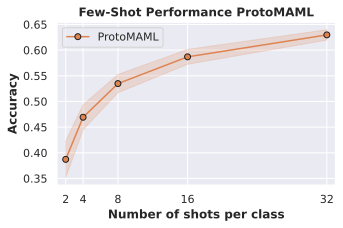

In [36]:
ax = plot_few_shot(protomaml_accuracies, name="ProtoMAML", color="C1")
plt.show()
plt.close()

---
# 8. Another Dataset Adapt
---

In [37]:
SVHN_test_dataset = SVHN(root='./', split='test', download=True, transform=transforms.ToTensor())

  0%|          | 0/64275384 [00:00<?, ?it/s]

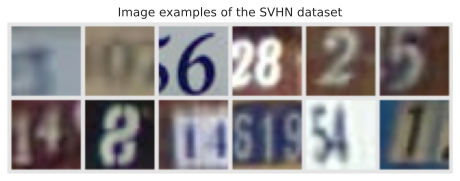

In [38]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [39]:
imgs = np.transpose(SVHN_test_dataset.data, (0,2,3,1))
targets = SVHN_test_dataset.labels
min_label_count = min(500, np.bincount(SVHN_test_dataset.labels).min())  # Limit number of examples to 500 to reduce test time

idxs = np.concatenate([np.where(targets==c)[0][:min_label_count] for c in range(1+targets.max())], axis=0)
imgs = imgs[idxs]
targets = torch.from_numpy(targets[idxs]).long()

svhn_fewshot_dataset = ImageDataset(imgs, targets, img_transform=test_transform)
svhn_fewshot_dataset.img.shape

(5000, 32, 32, 3)

In [40]:
protomaml_svhn_accuracies = dict()
for k in [2, 4, 8, 16, 32, 64]:
    protomaml_svhn_accuracies[k] = test_protomaml(protomaml_model, svhn_fewshot_dataset, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protomaml_svhn_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_svhn_accuracies[k][1]:4.2f}%)")

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=2: 16.67% (+-1.66%)


Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=4: 20.66% (+-1.60%)


Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=8: 27.41% (+-1.81%)


Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=16: 35.96% (+-1.84%)


Performing few-shot finetuning: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Accuracy for k=32: 46.04% (+-0.95%)


Performing few-shot finetuning: 0it [00:00, ?it/s]

Accuracy for k=64: 55.97% (+-1.14%)
